<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : KASRA MALIHI
### Student Number : 99105742
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [4]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')


efigi_png downloaded!
efigi_tables downloaded!


In [5]:
df.head(10)

,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2
5,PGC0000282,Spirals,2
6,PGC0000451,Spirals,2
7,PGC0000548,Spirals,2
8,PGC0000635,Spirals,2
9,PGC0000639,Spirals,2


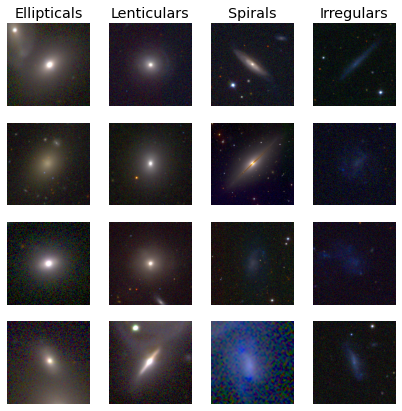

In [6]:
##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################
from PIL import Image
fig = plt.figure(figsize=(7, 7))
i = 0
for ind in df.index:
  if df['class_label'][ind] == 0 and i < 4:
    img_grid = fig.add_subplot(4, 4, 4 * i + 1)
    plt.axis('off')
    if i == 0:
      plt.title(df['class_name'][ind])
    i += 1
    name = df['name'][ind]
    address = './efigi-1.6/png/' + name + '.png'
    #img = plt.imread(address)
    img = Image.open(address, mode = 'r') 
    img_grid.imshow(img)
i = 0
for ind in df.index:
  if df['class_label'][ind] == 1 and i < 4:
    img_grid = fig.add_subplot(4, 4, 4 * i + 2)
    plt.axis('off')
    if i == 0:
      plt.title(df['class_name'][ind])
    i += 1
    name = df['name'][ind]
    address = './efigi-1.6/png/' + name + '.png'
    #img = plt.imread(address)
    img = Image.open(address, mode = 'r') 
    img_grid.imshow(img)
i = 0
for ind in df.index:
  if df['class_label'][ind] == 2 and i < 4:
    img_grid = fig.add_subplot(4, 4, 4 * i + 3)
    plt.axis('off')
    if i == 0:
      plt.title(df['class_name'][ind])
    i += 1
    name = df['name'][ind]
    address = './efigi-1.6/png/' + name + '.png'
    #img = plt.imread(address)
    img = Image.open(address, mode = 'r') 
    img_grid.imshow(img)
i = 0
for ind in df.index:
  if df['class_label'][ind] == 3 and i < 4:
    img_grid = fig.add_subplot(4, 4, 4 * i + 4)
    plt.axis('off')
    if i == 0:
      plt.title(df['class_name'][ind])
    i += 1
    name = df['name'][ind]
    address = './efigi-1.6/png/' + name + '.png'
    #img = plt.imread(address)
    img = Image.open(address, mode = 'r') 
    img_grid.imshow(img)
plt.show()

# Define Dataset (20 Points)

In [7]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################

class GalaxyDataSet(Dataset):
    def __init__(self, df):
      self.df = df
      self.image_array = []
      self.target_array = []
      for index in df.index:
        name = df['name'][index]
        address = './efigi-1.6/png/' + name + '.png'
        img = plt.imread(address)
        transformed_img = transforms.ToTensor()(img) 
        self.image_array.append(transformed_img)
        target = df['class_label'][index]
        self.target_array.append(target)

    def __len__(self):
      return len(self.df)

    def __getitem__(self, index):
      img = self.image_array[index]
      target = self.target_array[index]
      return img, target

gds = GalaxyDataSet(df)

# Define Model (20 Points)

In [8]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

def linear_relu(dim_in, dim_out):
    return [nn.Linear(dim_in, dim_out), nn.ReLU(inplace=True)]

class ClassifierModel(nn.Module):
    def __init__(self, input_size, number_of_classes):
      super(ClassifierModel, self).__init__()
      self.classifier = nn.Sequential(
          *linear_relu(input_size, 1024),
          *linear_relu(1024, 256),
          nn.Linear(256, number_of_classes)
        )


    def forward(self, x):
      x = x.view(-1, 255*255*3)
      y = self.classifier(x)
      return y

# Train Model (30 Points)

In [9]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################
num_class = 4
input_size = 255 * 255 * 3
model = ClassifierModel(input_size, num_class).to(device)
optimizer = torch.optim.Adam(model.parameters())
f_loss = torch.nn.CrossEntropyLoss()
print(model)
print(f_loss)
num_threads = 2
batch_size  = 128
nb_train_val = int(0.7 * len(gds))
nb_test =  len(gds) - nb_train_val
train_val_set, test_set = torch.utils.data.random_split(gds, [nb_train_val, nb_test])
nb_train = int(0.8 * len(train_val_set))
nb_val = len(train_val_set) - nb_train
train_set, val_set = torch.utils.data.random_split(train_val_set, [nb_train, nb_val])
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size, shuffle=True, num_workers=num_threads)
valid_loader = torch.utils.data.DataLoader(dataset=val_set,batch_size=batch_size, shuffle=False,num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False,num_workers=num_threads)
def test(model, loader, f_loss, device):
    with torch.no_grad():
        model.eval()
        N = 0
        tot_loss, correct = 0.0, 0.0
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            N += inputs.shape[0]
            tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()
            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()
        return tot_loss/N, correct/N
def train(model, loader, f_loss, optimizer, device):
    model.train()
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = f_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

val_loss_list = []
val_acc_list = []
train_loss_list = []
train_acc_list = []
val_loss_min = np.Inf
epochs = 25

for t in range(epochs):
    print("Epoch {}".format(t+1))
    train(model, train_loader, f_loss, optimizer, device)
    val_loss, val_acc = test(model, valid_loader, f_loss, device)
    train_loss, train_acc = test(model, train_loader, f_loss, device)
    if (val_loss < val_loss_min):
      val_loss_min = val_loss
      torch.save(model.state_dict(),'model.pt')
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(" Training : Loss : {:.4f}, Acc : {:.4f}".format(train_loss, train_acc))
    print(" Validation : Loss : {:.4f}, Acc : {:.4f}".format(val_loss, val_acc))

ClassifierModel(
  (classifier): Sequential(
    (0): Linear(in_features=195075, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
)
CrossEntropyLoss()
Epoch 1
 Training : Loss : 0.8796, Acc : 0.7424
 Validation : Loss : 0.8286, Acc : 0.7660
Epoch 2
 Training : Loss : 0.8651, Acc : 0.7592
 Validation : Loss : 0.9287, Acc : 0.7548
Epoch 3
 Training : Loss : 0.6965, Acc : 0.7548
 Validation : Loss : 0.7542, Acc : 0.7612
Epoch 4
 Training : Loss : 0.7496, Acc : 0.7817
 Validation : Loss : 0.9039, Acc : 0.6458
Epoch 5
 Training : Loss : 0.4887, Acc : 0.7945
 Validation : Loss : 0.6157, Acc : 0.7692
Epoch 6
 Training : Loss : 0.4057, Acc : 0.8169
 Validation : Loss : 0.6063, Acc : 0.7644
Epoch 7
 Training : Loss : 0.4207, Acc : 0.9018
 Validation : Loss : 0.7183, Acc : 0.7212
Epoch 8
 Training : Loss : 0.2237, Acc : 0.9579
 Valida

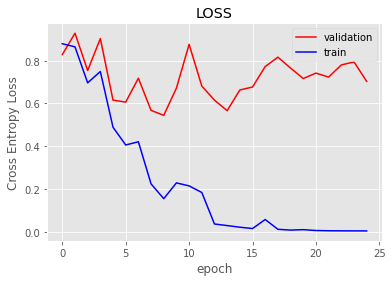

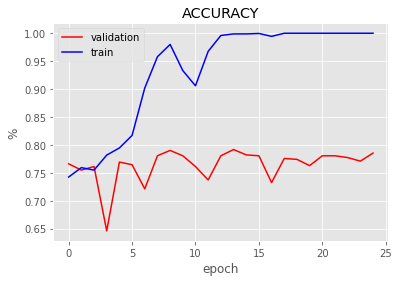

In [11]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
plt.plot(val_loss_list, 'r-',label='validation')
plt.plot(train_loss_list, 'b-',label='train')
plt.title('LOSS')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()
plt.plot(val_acc_list, 'r-',label='validation')
plt.plot(train_acc_list, 'b-',label='train')
plt.title('ACCURACY')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('%')
plt.show()

# Test Model (20)

Accuracy : 76.98%


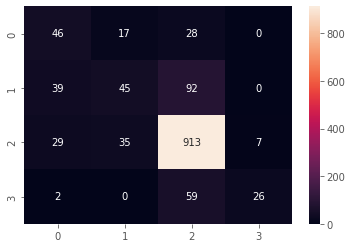

In [44]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
num_class = 4
input_size = 255 * 255 * 3
model = ClassifierModel(input_size, num_class).to(device)
model.load_state_dict(torch.load('model.pt'))
loss = 0
true_predict = 0
y_true = []
y_pred = []
for (data, label) in test_loader:
  output = model(data.to(device))
  pred = torch.argmax(output, dim = 1)
  y_true.append(list(label.cpu().numpy()))
  y_pred.append(list(pred.cpu().numpy()))
  true_predict += torch.sum(pred == label.to(device)).item()
accuracy = true_predict / len(test_loader.sampler)
print('Accuracy : {:.2%}'.format(accuracy))
from itertools import chain
y_true = list(chain.from_iterable(y_true))
y_pred = list(chain.from_iterable(y_pred))
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d')